### Importação das bibliotecas necessárias

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import six

from random import randint

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from scipy.ndimage import morphology as mp

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.keras.utils import get_source_inputs
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, Concatenate, MaxPooling2D
from tensorflow.keras.layers import Activation, SpatialDropout2D
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img

from tqdm import tqdm_notebook

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.regularizers import l2
from keras.applications import VGG16

2024-03-23 15:17:15.104737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 15:17:15.104765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 15:17:15.105385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 15:17:15.109327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Verifica se a GPU está disponível para uso pelo TensorFlow

In [2]:
print("GPU Available" if len(tf.config.list_physical_devices('GPU')) > 0 else "GPU Not Detected")

GPU Available


2024-03-23 15:17:16.594069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:17:16.612217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:17:16.612465: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
from os import listdir

image_path = './data/images_cut/'
labels_path = './data/labels_cut/'

file_names = [filename for filename in listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.3, random_state=42)

train_imgs= [image_path + i for i in train_files]
train_masks= [ labels_path + i for i in train_files]

val_imgs = [image_path + i for i in val_files]
val_masks = [labels_path + i for i in val_files]

In [4]:
print("Training images:", len(train_imgs))
print("Validation images:", len(val_imgs))

Training images: 70
Validation images: 30


In [5]:
img_size_ori = 101
img_size_target = (224, 840)
img_w_target = 224
img_h_target = 224

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)
    
def downsample(img):
    return resize(img, (img_w_target, img_h_target), mode='constant', preserve_range=True)

### Definição do gerador de dados

Será necessário para evitar que todas as imagens sejam carregadas em memória.
Fonte: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [6]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    
    def __init__(self, images, labels, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        list_IDs_temp = [k for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        batch_imgs = list()
        batch_labels = list()

        for i in list_IDs_temp:
            img = load_img(self.images[i], target_size=self.dim, grayscale=False)
            img = img_to_array(img)/255
            batch_imgs.append(img)
            label = load_img(self.labels[i] ,target_size=self.dim, grayscale=False)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)
            
        return np.array(batch_imgs, dtype = np.float32), np.array(batch_labels , dtype = np.float32 )

In [7]:
batch_size = 16
train_generator = DataGenerator(train_imgs, train_masks, batch_size=batch_size, dim=(224,224,3), shuffle=True)
train_generator.__getitem__(1)
train_steps = train_generator.__len__()

/tmp/ipykernel_18498/4250202541.py:43: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_18498/4250202541.py:44: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


In [8]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

def display_sample(data_tuple, img_shape):
    X,y = data_tuple
    plt.figure(figsize=(8,8))
    plt.subplot(121)
    plt.imshow(X[0])
    plt.subplot(122)
    plt.imshow(np.reshape(y[0], img_shape))

/tmp/ipykernel_18498/4250202541.py:43: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_18498/4250202541.py:44: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


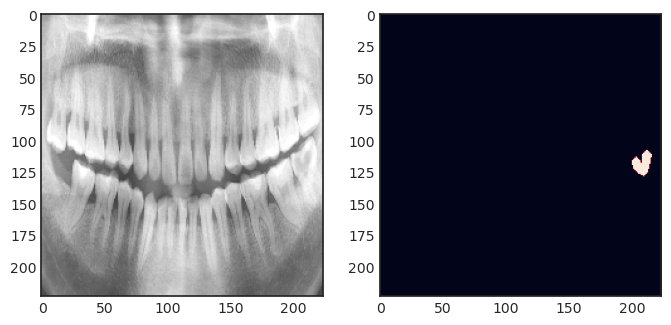

In [9]:
display_sample(train_generator.__getitem__(1), (224,224))

/tmp/ipykernel_18498/4250202541.py:43: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_18498/4250202541.py:44: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


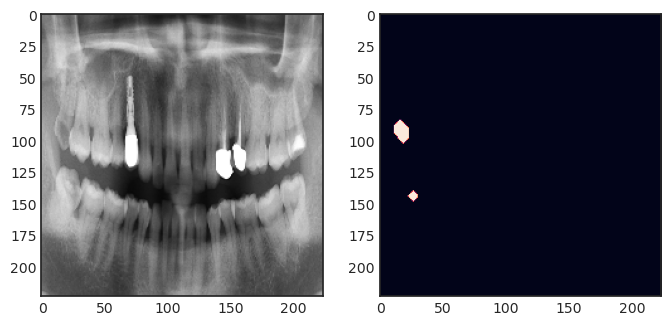

In [10]:
val_generator = DataGenerator(val_imgs, val_masks, batch_size=batch_size, dim=(224,224,3), shuffle=True)
val_steps = val_generator.__len__()
val_images = val_generator.images

display_sample(val_generator.__getitem__(0), (224, 224))

# Modelo de U-Net com backbone constrúido com VGG16 pré-treinada

In [11]:
def getLayerIndexByName(model, layername):
    for idx, layer in enumerate(model.layers):
        if layer.name == layername:
            return idx

In [12]:
def conv_block(inputs, filterCount, kernel_size=3):
    x = Conv2D(filterCount, kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filterCount, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def decoder_block(inputs, skip_features, filter_count):
    
    x = Conv2DTranspose(filter_count, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, filter_count, 3)
    return x


In [13]:
def UnetVgg(input_shape):
    inputs = Input(input_shape)
    print(inputs.shape)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor = inputs)

    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output
    
    center = vgg16.get_layer("block5_conv3").output
    
    d1 = decoder_block(center,skip4,512)
    d2 = decoder_block(d1,skip3,256)
    d3 = decoder_block(d2,skip2,128)
    d4 = decoder_block(d3,skip1,64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

(None, 224, 224, 3)


2024-03-23 15:17:18.192801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:17:18.193035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:17:18.193214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

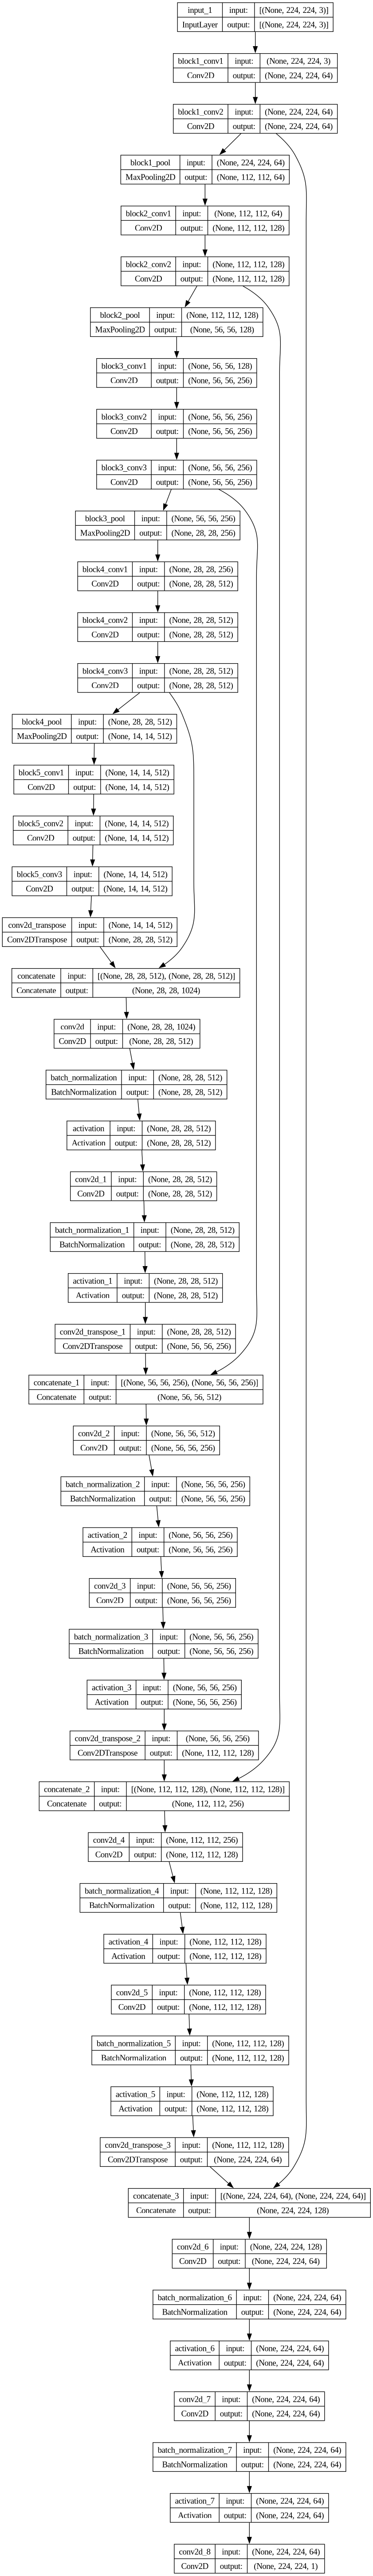

In [14]:
model = UnetVgg(input_shape=(224,224, 3))
model.summary()
plot_model(model, show_shapes=True)

### Métricas de perda customizadas

O índice de Jaccard é útil para situações onde as classes são desbalanceadas.

In [15]:
from keras.losses import binary_crossentropy

def jaccard_distance_loss(y_true, y_pred):
    # https://en.wikipedia.org/wiki/Jaccard_index
    smooth = 1
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    print("y_true_f", y_true_f)
    print("Score", 1. - score)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    print("y_true, y_pred", y_true, y_pred)
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [16]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top.weights.h5', monitor='dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
# es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = [mc]
model.metrics_names

[]

In [17]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

2024-03-23 15:17:19.111973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:17:19.112315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-23 15:17:19.112677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
model_history = model.fit(train_generator, steps_per_epoch=train_steps,epochs=60,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

/tmp/ipykernel_18498/4250202541.py:43: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_erosion(mp.binary_erosion(label))
/tmp/ipykernel_18498/4250202541.py:44: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))


Epoch 1/60
y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_8/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
y_true_f Tensor("bce_dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("bce_dice_loss/sub:0", shape=(), dtype=float32)
y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_8/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
y_true_f Tensor("bce_dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("bce_dice_loss/sub:0", shape=(), dtype=float32)


2024-03-23 15:17:22.376663: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-23 15:17:25.749286: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 15:17:26.110698: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.42GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-23 15:17:26.906296: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

4/4 [==============================] - ETA: 0s - loss: 1.5680 - dice_coef: 0.0103 - accuracy: 0.7558y_true, y_pred Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32) Tensor("VGG16_U-Net/conv2d_8/Sigmoid:0", shape=(None, None, None, 1), dtype=float32)
y_true_f Tensor("bce_dice_loss/Reshape:0", shape=(None,), dtype=float32)
Score Tensor("bce_dice_loss/sub:0", shape=(), dtype=float32)

Epoch 1: dice_coef improved from -inf to 0.01026, saving model to top.weights.h5
4/4 [==============================] - 31s 1s/step - loss: 1.5680 - dice_coef: 0.0103 - accuracy: 0.7558 - val_loss: 2.0109 - val_dice_coef: 0.0079 - val_accuracy: 0.2526
Epoch 2/60
4/4 [==============================] - ETA: 0s - loss: 1.3489 - dice_coef: 0.0073 - accuracy: 0.9877
Epoch 2: dice_coef did not improve from 0.01026
4/4 [==============================] - 3s 670ms/step - loss: 1.3489 - dice_coef: 0.0073 - accuracy: 0.9877 - val_loss: 1.5433 - val_dice_coef: 0.0077 - val_accuracy: 0.7508
Epoch

In [19]:
model_history.history.keys()

dict_keys(['loss', 'dice_coef', 'accuracy', 'val_loss', 'val_dice_coef', 'val_accuracy'])

In [20]:
loss = model_history.history["loss"]

accuracy = model_history.history["accuracy"]

val_loss = model_history.history["val_loss"]

val_accuracy = model_history.history["val_accuracy"]

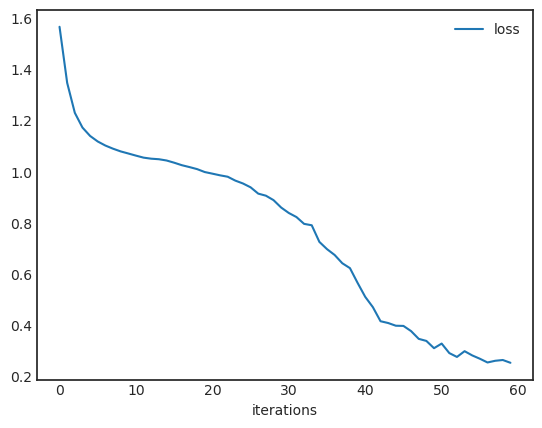

In [21]:
plt.plot(loss,label = "loss")
plt.xlabel("iterations")
plt.legend()

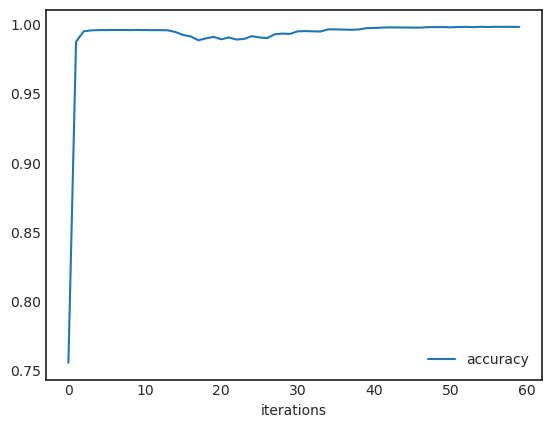

In [22]:
plt.plot(accuracy,label = "accuracy")
plt.xlabel("iterations")
plt.legend()

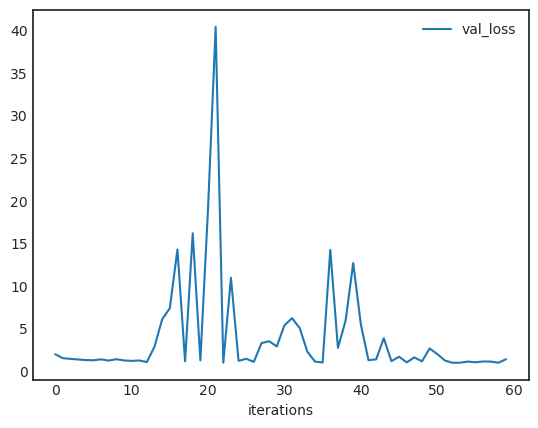

In [23]:
plt.plot(val_loss,label = "val_loss")
plt.xlabel("iterations")
plt.legend()

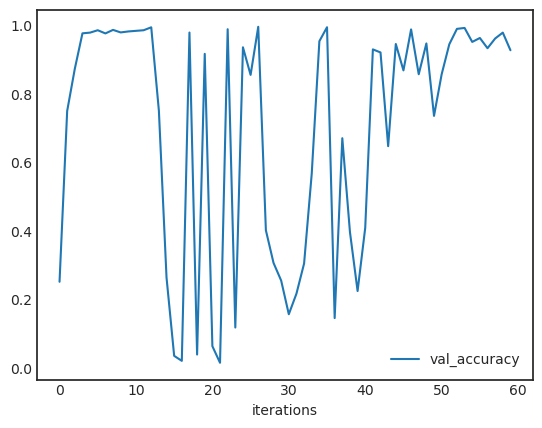

In [24]:
plt.plot(val_accuracy,label = "val_accuracy")
plt.xlabel("iterations")
plt.legend()

In [25]:
model.save_weights('top.weights.h5')

In [26]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)
    
    mask = (mask[0] > 0.5)*1
    mask = np.reshape(mask,(224,224))
    return mask      

(224, 224, 3)

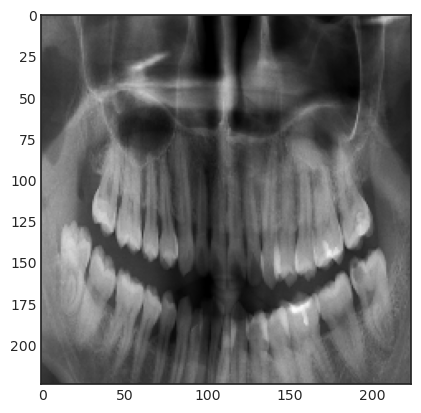

In [27]:
image = './data/images_cut/' + train_files[4]
img = img_to_array(load_img(image, target_size=(224,224,3)))
plt.imshow(img/255.)
img.shape

1/1 [==============================] - 2s 2s/step


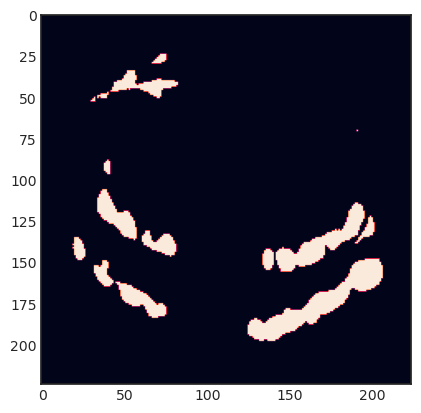

In [28]:
mask = make_prediction(model,image,(224,224,3))
plt.imshow(mask)